In [1]:
%matplotlib inline

In [2]:
import librosa
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale

from IPython.display import Audio

# Audio features extraction

Before we able to train our models, an important step is to extract the audio features from the audio files. This is needed because the audio data cannot be understood by the models. This notebook describes the most important audio features we use and the process of their extraction.

In [3]:
audio_data = "data/hiphop/hiphop.00001.wav"
y, sampling_rate = librosa.load(audio_data)

In [4]:
Audio(data = y, rate = sampling_rate)

## Extracting statistical measures

One common thing about the audio features is their very big size. The size of each feature is equal to the number of frames in the signal. We cannot process all of them. A common approach is calculate the statistical measures for each feature instead. For most of the extracted feature we are going calculate: min, max, mean, std, skewness and kurtosis. So the whole time series for an our feature with produce six audio features.

```python
    def statistical_measures(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
```

## Zero crossing rate

The zero crossing rate is the rate the audio signal changes it sign from positive to negative or back. This feature  is used in both speech detection and music information retrieval.

In [5]:
start = 0
end = 20000

In [6]:
y_sample = y[start:end]

In [7]:
zero_line = np.zeros(end)

In [8]:
def normalize(y, axis = 0):
    return minmax_scale(y, axis=0)

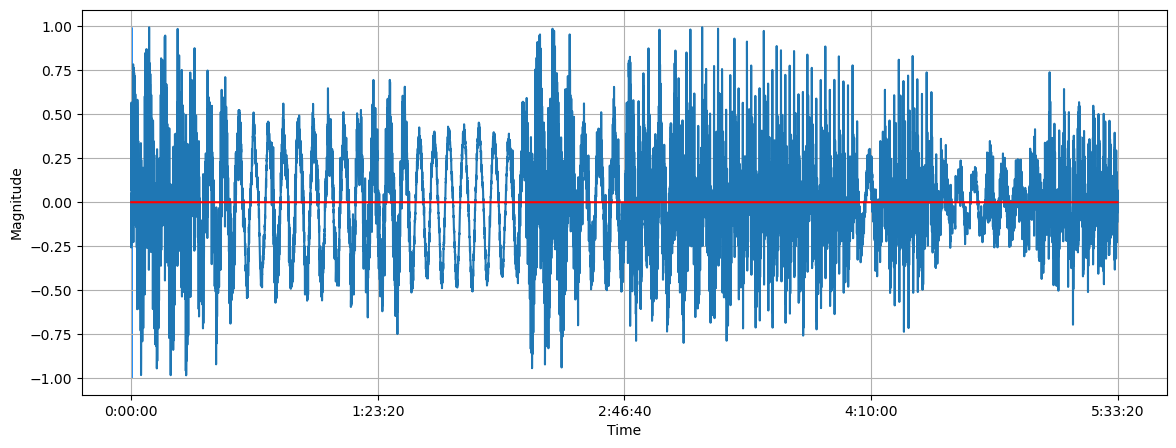

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(y_sample)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.grid()
librosa.display.waveshow(y_sample, sr = sampling_rate, color="dodgerblue")
plt.plot(zero_line, color = "red")
plt.show()

## Spectral Centroid

The spectral centroid is a measure used in digital signal processing to characterize a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

In [10]:
spectral_centroids = librosa.feature.spectral_centroid(y = y_sample, sr=sampling_rate).ravel()
frames = range(len(spectral_centroids))
time = librosa.frames_to_time(frames)

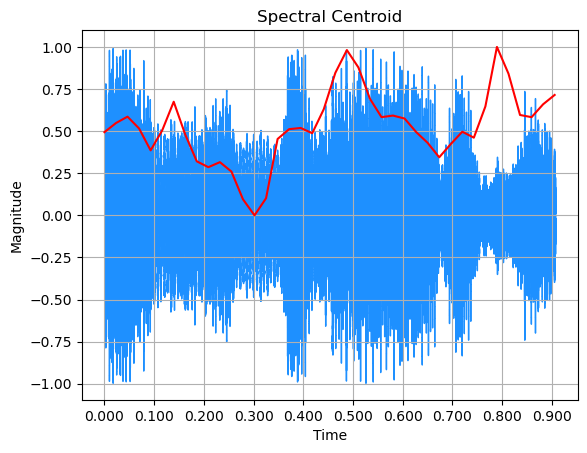

In [11]:
librosa.display.waveshow(y_sample, sr = sampling_rate, color="dodgerblue")
plt.grid()
plt.title("Spectral Centroid")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.plot(time, normalize(spectral_centroids), color='r')
plt.show()

It is calculated using weighted mean of the frequencies present signal, determined using Fourier transform.

$$
C = \frac{\sum_{n=0}^{N-1}f(n)x(n)}{\sum_{n=0}^{N-1}x(n)}
$$

$x(n)$ - weighted frequency value of histogram bin with number n\
$f(n)$ - represents the center frequency of that bin

## Spectral Contrast

Spectral contrast considers the spectral peak, the spectral valley, and their difference in each frequency sub-band.

In [12]:
spectral_contrast = librosa.feature.spectral_contrast(y = y_sample, sr=sampling_rate)

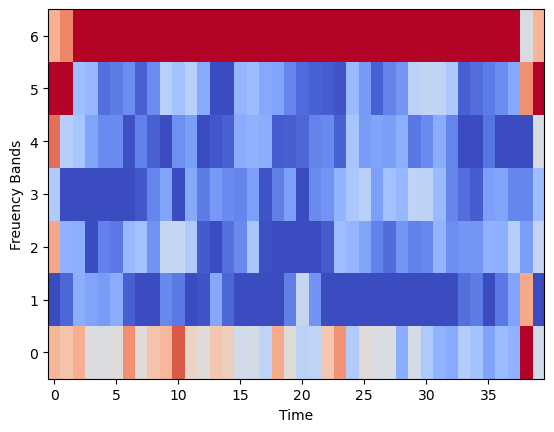

In [13]:
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
plt.ylabel("Freuency Bands")
plt.xlabel("Time")
plt.show()

## MFCC - Mel-Frequency Cepstral Coefficients

These represent a small set of features (usually about 10 - 20) which concisely describe the overall shape of a spectral envelope.

To calculate them we start with a short window frame (20 to 40 ms) in which we can assume that the audio signal is stationary. We than select a short frame step of around 10 ms. We can compute the power spectrum of each frame through periodogram, which is inspired by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. To do so, we start with Discrete Fourrier Transform of the frame:

$$
S_{i}(k) = \sum_{n=1}^{N}s_{i}(n)h(n)e^{-j2\pi kn/N}
$$

Where:

* $s_{i}(n)$ is the framed signal in i frames
* $N$ is the number of samples in a Hamming Window
* $h(n)$ is the Hamming Window
* $K$ is the length of the DFT

To compute the periodogram estimate of the power spectrum, we apply:

$$ 
P_{i}(k) = \frac{1}{N}|S_{i}(k)|^{2}
$$

Since the cochlea is not so good to discriminate between two closely spaced frequencies, especially when they are high, we take clumps of periodogram bins and sum them up. This is done by applying Mel filterbank, filters which tell us exactly how to space our filterbanks and how wide to make them. These filters are typically narrower around 0 Hz and wider for higher frequencies.

![Melfb](images/melfb.png)

The formula to move from frequencies to Mel scale is the following:
$$
M(f) = 1125\ln{(1 + \frac{f}{100})}
$$

The Mel filterbank is a set of 26 triangular filters which we apply to the periodogram power spectral estimate. Each filter is mostly made of 0's but has a non-zero triangle in some region. We multiply the values of the periodogram by the ones of the filters.

![Melfb2](images/melfb2.png)

We then take the logarithm of the all those 26 series of energy of those filterbanks since we do not percieve loudness linearly, but close to logarithmically.

We finally apply a Discrete Cosine Transform to the 26 log filterbank energies in order to decorrelate the overlapping filterbanks energies. This gives us 26 coefficients, called the MFCC. Not all of them are useful, and for Automatic Speech Recognition, we typically only use the 12-13 lower values.

MFCCs are widely used to classify phonemes. They can easily be extracted using librosa library:

In [14]:
mfcc = librosa.feature.mfcc(y = y_sample)

In our code we handle it this way:

```python

mfcc = librosa.feature.mfcc(y = y, sr = sampling_rate, n_mfcc = 13)
for idx, v_mfcc in enumerate(mfcc):
    features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
```

## Spectral Rolloff

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy lies, e.g. 85%.

In [15]:
spectral_rolloff = librosa.feature.spectral_rolloff(y = y_sample, sr=sampling_rate).ravel()
frames = range(len(spectral_rolloff))
time = librosa.frames_to_time(frames)

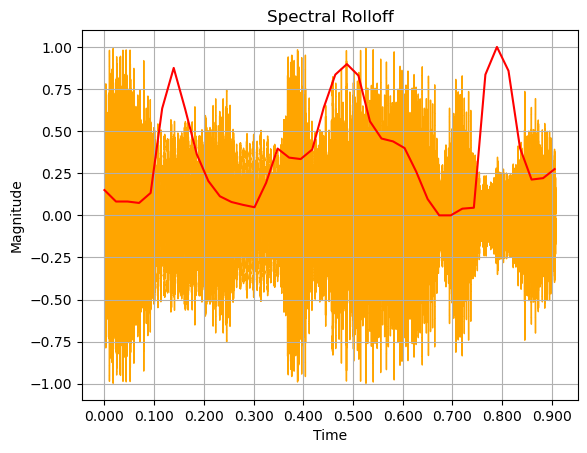

In [16]:
plt.grid()
librosa.display.waveshow(y = y_sample, sr = sampling_rate, color="orange")
plt.title("Spectral Rolloff")
plt.ylabel("Magnitude")
plt.xlabel('Time')
plt.plot(time, normalize(spectral_rolloff), color="r")
plt.show()

## Spectral Bandwidth

The order p spectral bandwidth is calculated using the sum:

$$
(\sum_{k}S(k)(f(k)-f_{c})^p)^\frac{1}{p}
$$

$S(k)$ is the spectral magnitude at frequency bin $k$
$f(k)$ is the frequency at bin k
$f_{c}$ is the spectral centroid

When $p=2$, this is like a weighted standard deviation.

In [17]:
spectral_bandwidth_p2 = librosa.feature.spectral_bandwidth(y=y_sample, sr=sampling_rate).ravel()
spectral_bandwidth_p3 = librosa.feature.spectral_bandwidth(y=y_sample, sr=sampling_rate, p=3).ravel()
spectral_bandwidth_p4 = librosa.feature.spectral_bandwidth(y=y_sample, sr=sampling_rate, p=4).ravel()

In [18]:
frames = range(len(spectral_bandwidth_p2))
time = librosa.frames_to_time(frames)

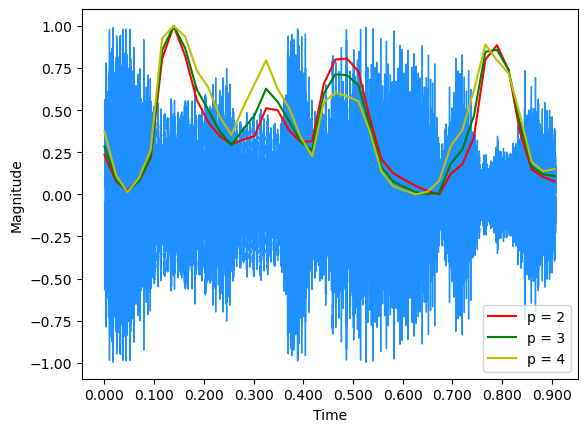

In [19]:
librosa.display.waveshow(y_sample, sr = sampling_rate, color="dodgerblue")
plt.plot(time, normalize(spectral_bandwidth_p2), color="r", label = "p = 2")
plt.plot(time, normalize(spectral_bandwidth_p3), color="g", label = "p = 3")
plt.plot(time, normalize(spectral_bandwidth_p4), color="y", label = "p = 4")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

## Spectral Flatness

Spectral flatness is defined as the ratio of the geometric mean to the arithmetic mean of a power spectrum.

In [20]:
spectral_flatness = librosa.feature.spectral_flatness(y = y).ravel()
frames = range(len(spectral_flatness))
time = librosa.frames_to_time(frames)

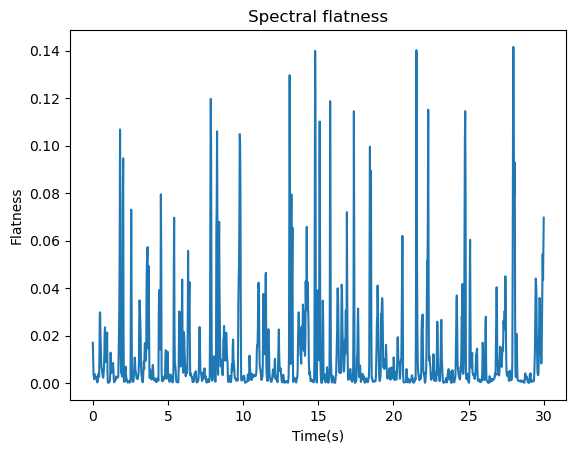

In [21]:
plt.plot(time, spectral_flatness)
plt.title("Spectral flatness")
plt.xlabel("Time(s)")
plt.ylabel("Flatness")
plt.show()

## Flux (Onset Strength)

Onset strength refers to a signal processing technique used in music analysis to detect the strength or prominence of the onset of a sound within a given audio signal. An onset is typically the beginning or the start of a musical note or sound.

In [22]:
onset_stenght = librosa.onset.onset_strength(y  = y_sample, sr=sampling_rate).ravel()

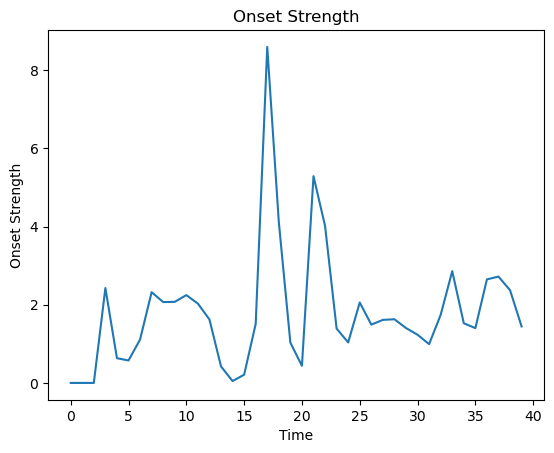

In [23]:
plt.plot(onset_stenght)
plt.title("Onset Strength")
plt.xlabel("Time")
plt.ylabel("Onset Strength")
plt.show()

## RMSE

RMSE is the Root Mean Squared Error of the signal.

## Feature Extraction Script

All samples in the dataset have fixed length of 30 seconds. With the following script we can extract the audio features and produce a csv file:

```python
python extraction.py -s 2 -o ../data/15_second_test.csv
```

Where:

-s is the number of segments. If s = 2 for example the 30 seconds sample will produce two observations with length 15 second each. If s = 3, three observation with 10 seconds each.

-o defines the output file.